In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import nltk
import re
import string
import seaborn as sns
from wordcloud import WordCloud
import spacy
from bs4 import BeautifulSoup
from tqdm import tqdm
tqdm.pandas()

In [2]:
pd.set_option('max_columns', None)
pd.set_option("max_rows", None)
pd.set_option("max_colwidth", 1000)

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/kro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
dataStack = pd.read_csv("../QueryResults.csv")
dataStack["CreationDate"] = pd.to_datetime(dataStack["CreationDate"])
dataStack["CreationYear"] = dataStack["CreationDate"].dt.year
dataStack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17808 entries, 0 to 17807
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Id                     17808 non-null  int64         
 1   PostTypeId             17808 non-null  int64         
 2   AcceptedAnswerId       15813 non-null  float64       
 3   ParentId               0 non-null      float64       
 4   CreationDate           17808 non-null  datetime64[ns]
 5   DeletionDate           0 non-null      float64       
 6   Score                  17808 non-null  int64         
 7   ViewCount              17808 non-null  int64         
 8   Body                   17808 non-null  object        
 9   OwnerUserId            17369 non-null  float64       
 10  OwnerDisplayName       2863 non-null   object        
 11  LastEditorUserId       16452 non-null  float64       
 12  LastEditorDisplayName  1944 non-null   object        
 13  L

In [5]:
dataStack.head()

Id  PostTypeId  AcceptedAnswerId  ParentId        CreationDate  \
0      7284           1            7320.0       NaN 2008-08-10 18:41:02   
1      7492           1               NaN       NaN 2008-08-11 03:00:26   
2      7551           1            7618.0       NaN 2008-08-11 05:44:42   
3  19551298           1               NaN       NaN 2013-10-23 20:06:51   
4   3301956           1         3302018.0       NaN 2010-07-21 17:15:13   

   DeletionDate  Score  ViewCount  \
0           NaN    566     210026   
1           NaN    246     161018   
2           NaN    834     311974   
3           NaN    226     231871   
4           NaN    206      63726   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Body  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 <p>What does the expression "Turing Complete" mean? </p>\n\n<p>Can you give a simple explanation, without going into too many theoretical details?</p>\n   
1  <p>In the past, I used Microsoft Web Application Stress Tool and Pylot to stress test web applications. I'd written a simple home page, login script, and site walkthrough (in an ecommerce site adding a few items to a cart and checkout).</p>\n\n<p>Just hitting the homepage hard with a handful of developers would almost always locate a major problem. More scalability problems would surface at the second stage, and even more - after the launch.</p>\n\n<p>The URL of the tools I used were Microsoft Homer (aka <a href="http://www.microsoft.com/downloads/details.aspx?familyid=e2c0585a-062a-439e-a67d-75a89aa36495&amp;displaylang=en" rel="noreferrer">Microsoft Web Application Stress Tool</a>) and <a href="https://code.google.com/archive/p/pylt/" rel="noreferrer">Pylot</a>.</p>\n\n<p>The reports generated by these tools never made much sense to me, and I would spend many hours trying to figure out what kind of concurrent load the site would be able to support. It was always worth it because ...   
2                                                                                                                                                                                                                                                                                     <p>When designing a REST API or service

<AxesSubplot:title={'center':'Evolution des questions'}, xlabel='Année', ylabel='Nombre de questions'>

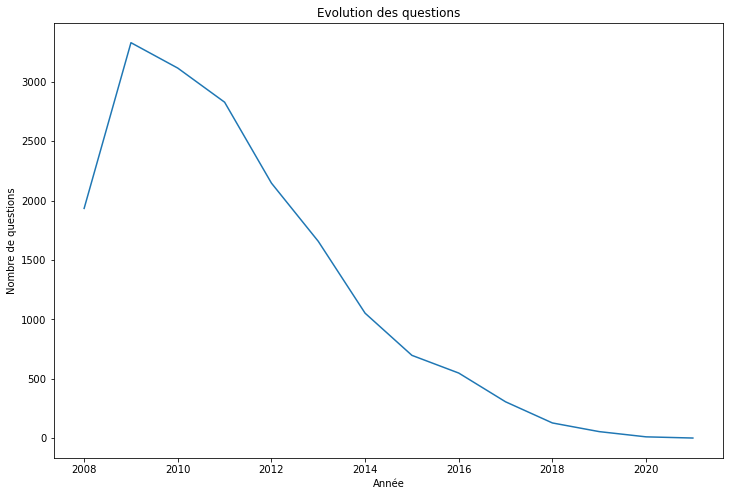

In [6]:
dataTemp = dataStack.groupby(by="CreationYear").count()
dataTemp = dataTemp.iloc[:,0]
fig = plt.figure(figsize=(20, 8))
dataTemp.plot(figsize=(12,8),
          title="Evolution des questions",
          ylabel="Nombre de questions",
          xlabel="Année",
          legend=False)

# Fonctions

In [7]:
def getListTag(listToWork,sep,years="All"):
    """ 
    Fonction qui compte le nombre de mots différents
    listToWork : Dataframe
    sep : Séparateur pour spliter
    years : l'année pour laquelle on travaille
    """
    tagList=[]
    tempData = dataStack.copy()
    
    if years != "All":
        tempData = tempData[tempData['CreationYear']==years]
    for tags in tempData[listToWork]:
        for mot in tags.split(sep):
            tagList.append(mot)
            
    dfTagList = pd.DataFrame(tagList, columns=["Tag"])
    dfTagList = dfTagList.groupby("Tag")\
        .agg(tagCount=pd.NamedAgg(column="Tag", aggfunc="count"))
    dfTagList.sort_values("tagCount", ascending=False, inplace=True)

    return dfTagList

In [8]:
def keep_info(listInfo,toKeep):
    """Return the list of information which is in the 'keep list'"""
    loc = []
    try:
        if listInfo != 'nan':
            for word in listInfo.split(','):
                if word in toKeep.index:
                    loc.append(word)
    except:
        print("Except ",listInfo)
    return ','.join(loc)

In [9]:
def nettoyageGe(listToClean):
    
    # Lower case
    locList = listToClean.lower()

    # Remove ponctuation sauf #
    locList = re.sub('[^\\w\\s#]', '', locList)
    # Remove digit
    locList = re.sub(r'\w*\d+\w*', '', locList)
    # Remove links
    locList = re.sub(r'http*\S+', '', locList)
    # Remove \n
    locList = locList.replace("\n"," ")
    # Change some words
    locList = locList.replace("i'm","i am")
    locList = locList.replace("i've","i have")
    locList = locList.replace("i'd","i would")
    locList = locList.replace("don't","do not")
    locList = locList.replace("that's","that is")
    # On supprime les espaces en trop
    locList=" ".join(locList.split())
    locList = locList.replace("c #","c#")
    locList = locList.replace("c#","cSharp")
    
    return(locList)

In [10]:
def getWord(listToWork):
    """ 
    Fonction qui compte le nombre de mots différents
    listToWork : Dataframe
    """
    motList=[]
    tempData = dataStack[listToWork].copy()
    
    for listData in tempData:
        for mot in listData:
            motList.append(mot)
            
    dfMotList = pd.DataFrame(motList, columns=["Mot"])
    dfMotList = dfMotList.groupby("Mot")\
        .agg(Count=pd.NamedAgg(column="Mot", aggfunc="count"))
    dfMotList.sort_values("Count", ascending=False, inplace=True)
    
    return dfMotList

# Tags

In [11]:
dataStack['MainTags']=dataStack['Tags'].str.replace("<","")
dataStack['MainTags']=dataStack['MainTags'].str.replace(">",",")
dataStack['MainTags']=dataStack['MainTags'].str[:-1]

In [12]:
listTags = getListTag('MainTags',',')
#listTags

In [13]:
#On garde les 40 plus utilisés
listTags=listTags.iloc[:40]
#listTags

<Figure size 1080x720 with 0 Axes>

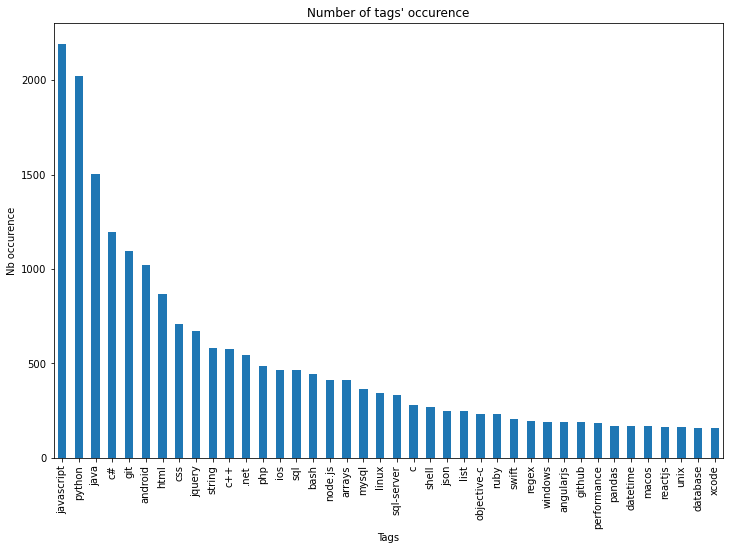

In [14]:
fig = plt.figure(figsize=(15, 10))

listTags.plot(figsize=(12,8), kind="bar",
          title="Number of tags' occurence",
          ylabel="Nb occurence",
          xlabel="Tags",
          legend=False)
plt.xticks(np.arange(len(listTags)),listTags.index)
plt.show()

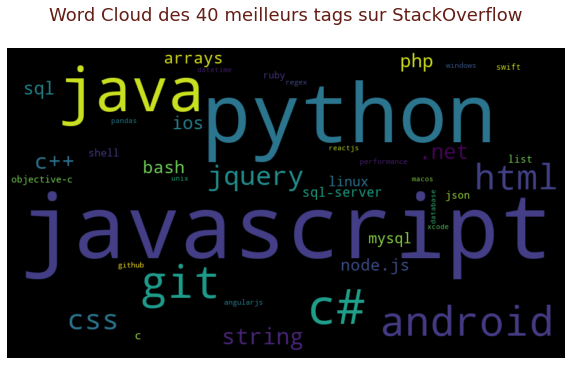

In [15]:
# Word cloud 
fig = plt.figure(1, figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(listTags.to_dict()['tagCount'])

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud des 40 meilleurs tags sur StackOverflow\n",
          fontsize=18, color="#641E16")
plt.show()

In [16]:
# keep top 40 tags
dataStack['MainTags']=dataStack['MainTags'].apply(lambda x : keep_info(x,listTags))

In [17]:
# On garde ceux qui ont des tags
dataStack=dataStack[dataStack['MainTags']!=""]

In [18]:
dataStack['MainTags']= dataStack['MainTags'].str.replace(',',' ')

In [19]:
dataStack['MainTags'].head()

1             performance
4                     git
5                     git
6    python string arrays
7                 c# list
Name: MainTags, dtype: object

In [20]:
# Tokenization
dataStack['MainTags'] = dataStack['MainTags'].apply(nltk.tokenize.word_tokenize)

# Title

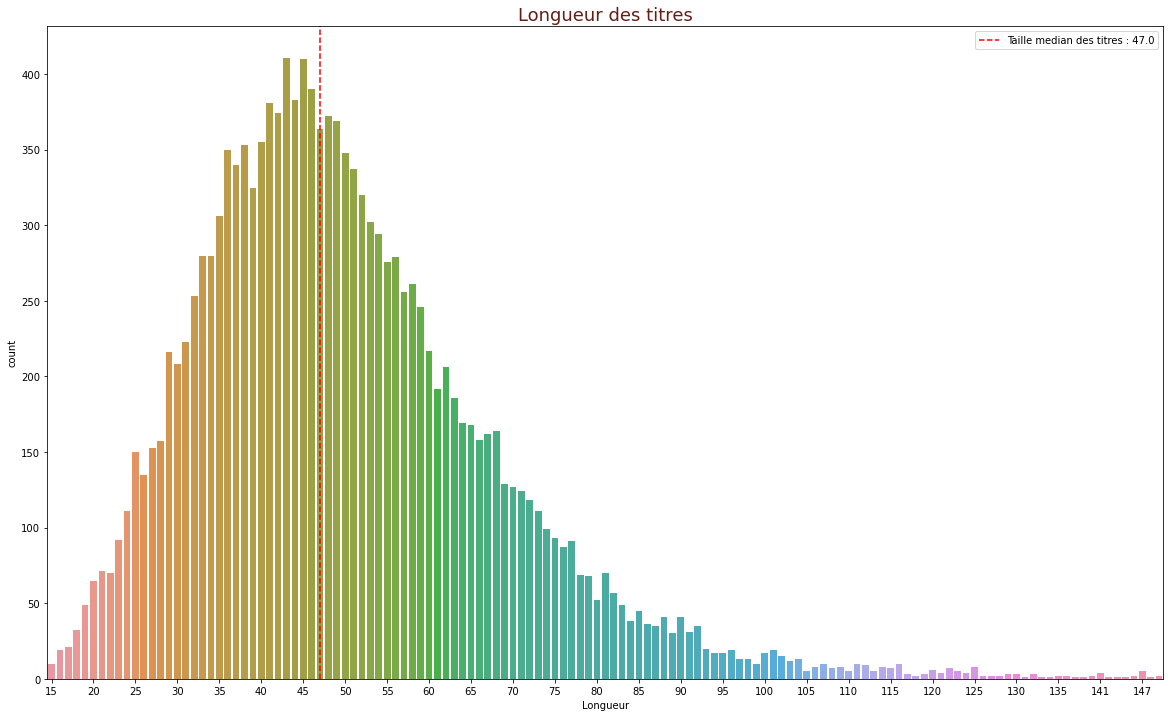

In [21]:
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=dataStack.Title.str.len())
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 5))
plt.axvline(dataStack.Title.str.len().median() - dataStack.Title.str.len().min(),
            color="r", linestyle='--',
            label="Taille median des titres : "+str(dataStack.Title.str.len().median()))
ax.set_xlabel("Longueur")
plt.title("Longueur des titres",
          fontsize=18, color="#641E16")
plt.legend()
plt.show()

In [22]:
dataStack['MainWordTitle'] = dataStack['Title'].progress_apply(lambda x : nettoyageGe(x))

100%|██████████| 14657/14657 [00:00<00:00, 105353.21it/s]


In [23]:
dataStack['Title'].head()

1                      Performing a Stress Test on Web Application?
4    Git: Correct way to change Active Branch in a bare repository?
5                            Are multiple `.gitignore`s frowned on?
6                                        Python csv string to array
7                 How to Sort a List<T> by a property in the object
Name: Title, dtype: object

In [24]:
dataStack['MainWordTitle'].head(20)

1                                                                       performing a stress test on web application
4                                                      git correct way to change active branch in a bare repository
5                                                                                are multiple gitignores frowned on
6                                                                                        python csv string to array
7                                                                   how to sort a listt by a property in the object
8     how to convert existing nonempty directory into a git working directory and push files to a remote repository
9                                                                                    remove duplicate rows in mysql
10                                          to prevent a memory leak the jdbc driver has been forcibly unregistered
11                                             what is the maximum recur

In [25]:
nlp = spacy.load('en_core_web_sm')
pos_list = ["NOUN","PROPN"]

In [26]:
# On garde nom et prono
def keepNomEtPronom(info):
    doc = nlp(info)
    list_text_row = []
    for token in doc:
        if(token.pos_ in pos_list):
            list_text_row.append(token.text)
    list_text = " ".join(list_text_row)
    list_text = list_text.replace("c #", "c#")
    list_text_row = []
    return list_text

In [27]:
dataStack['MainWordTitle'] = dataStack['MainWordTitle'].progress_apply(lambda x : keepNomEtPronom(x))

100%|██████████| 14657/14657 [00:41<00:00, 356.10it/s]


In [28]:
dataStack['MainWordTitle'].head(20)

1                  stress test web application
4                    git way branch repository
5                                   gitignores
6                            python csv string
7                        listt property object
8     directory git directory files repository
9                                   rows mysql
10                     memory leak jdbc driver
11                      recursion depth python
12    database table column naming conventions
13                          links shell script
14                         type namespace name
16                                 pack effect
17                                     request
18                   reasons properties cSharp
19                                 button form
20             console error internet explorer
21                                       shell
22              class see instance method ruby
23                uitableviewcell button swipe
Name: MainWordTitle, dtype: object

In [29]:
# Tokenization
dataStack['MainWordTitle'] = dataStack['MainWordTitle'].apply(nltk.tokenize.word_tokenize)

In [30]:
dataStack['MainWordTitle'].head(20)

1                   [stress, test, web, application]
4                     [git, way, branch, repository]
5                                       [gitignores]
6                              [python, csv, string]
7                          [listt, property, object]
8     [directory, git, directory, files, repository]
9                                      [rows, mysql]
10                      [memory, leak, jdbc, driver]
11                        [recursion, depth, python]
12    [database, table, column, naming, conventions]
13                            [links, shell, script]
14                           [type, namespace, name]
16                                    [pack, effect]
17                                         [request]
18                     [reasons, properties, cSharp]
19                                    [button, form]
20              [console, error, internet, explorer]
21                                           [shell]
22              [class, see, instance, method,

In [31]:
# Lemmatizer
wn = nltk.WordNetLemmatizer()
dataStack['MainWordTitle'] = dataStack['MainWordTitle'].apply(lambda x : [wn.lemmatize(word) for word in x])

In [32]:
dataStack['MainWordTitle'].head(20)

1                  [stress, test, web, application]
4                    [git, way, branch, repository]
5                                      [gitignores]
6                             [python, csv, string]
7                         [listt, property, object]
8     [directory, git, directory, file, repository]
9                                      [row, mysql]
10                     [memory, leak, jdbc, driver]
11                       [recursion, depth, python]
12    [database, table, column, naming, convention]
13                            [link, shell, script]
14                          [type, namespace, name]
16                                   [pack, effect]
17                                        [request]
18                       [reason, property, cSharp]
19                                   [button, form]
20             [console, error, internet, explorer]
21                                          [shell]
22             [class, see, instance, method, ruby]
23          

In [33]:
# StopWords
sw = set()
sw.update(tuple(nltk.corpus.stopwords.words('english')))

dataStack['MainWordTitle'] = dataStack['MainWordTitle'].apply(lambda x : [mot for mot in x
                       if mot not in sw])

In [34]:
listTitle = getWord('MainWordTitle')

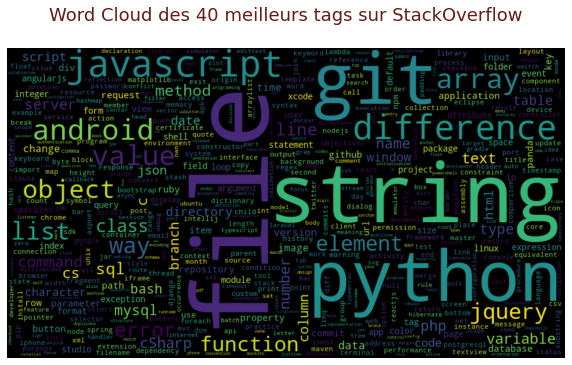

In [35]:
# Word cloud 
fig = plt.figure(1, figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(listTitle.to_dict()['Count'])

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud des 40 meilleurs tags sur StackOverflow\n",
          fontsize=18, color="#641E16")
plt.show()

# Body

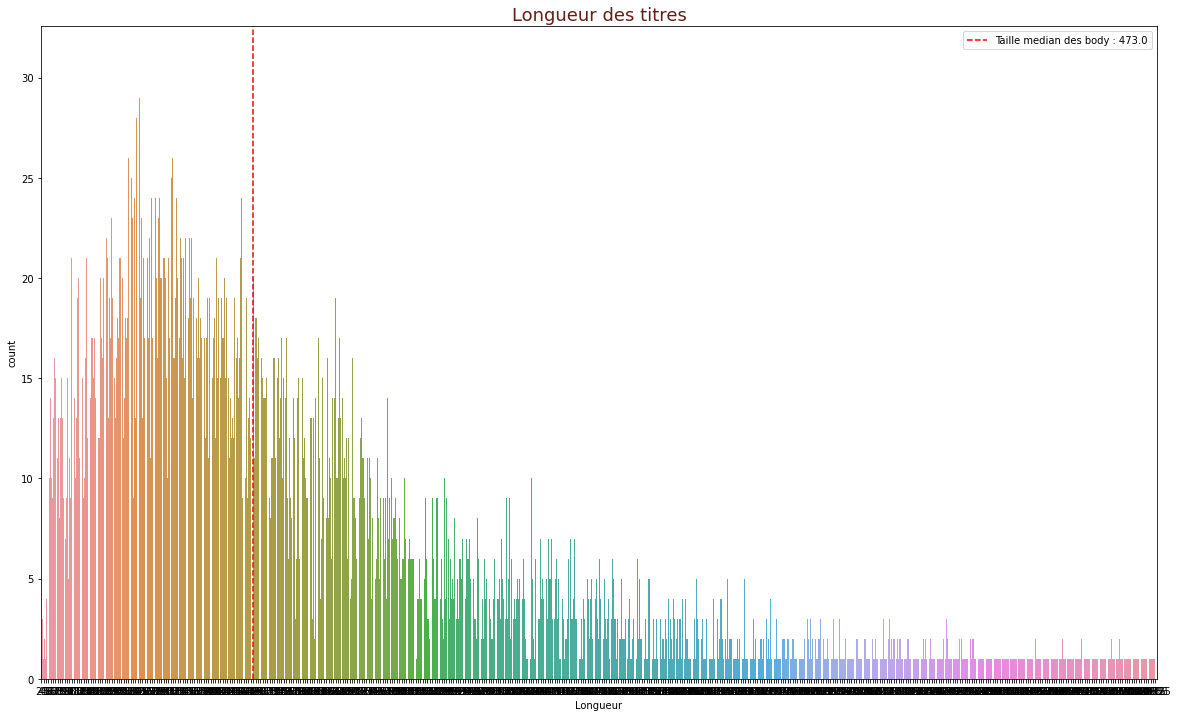

In [36]:
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=dataStack.Body.str.len())
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 5))
plt.axvline(dataStack.Body.str.len().median() - dataStack.Body.str.len().min(),
            color="r", linestyle='--',
            label="Taille median des body : "+str(dataStack.Body.str.len().median()))
ax.set_xlabel("Longueur")
plt.title("Longueur des titres",
          fontsize=18, color="#641E16")
plt.legend()
plt.show()

In [37]:
# Supprimer les tag <code>
def SuppCode(x):
    soup = BeautifulSoup(x,"html.parser")
    code_to_remove = soup.findAll("code")
    for code in code_to_remove:
        code.replace_with(" ")
    return str(soup)

In [38]:
# Regrouper c et #
def RegCSharp(x):
    test = x.copy()
    while '#' in test : 
        idx = test.index('#')
        if(test[idx-1]=='c'):
            test[idx]="c#"
            del(test[idx-1])
        else:
            del(test[idx])
    return(test)

In [39]:
#dataStack['Body'].head()

In [40]:
# Delete htlm et code tags
dataStack['MainWordBody'] = dataStack['Body'].apply(SuppCode)
# Delete all html tags
dataStack['MainWordBody'] = [BeautifulSoup(text,"html.parser").get_text() for text in dataStack['MainWordBody']]

#Nettoyage général
dataStack['MainWordBody'] = dataStack['MainWordBody'].progress_apply(lambda x : nettoyageGe(x))

100%|██████████| 14657/14657 [00:00<00:00, 22361.94it/s]


In [41]:
#dataStack['MainWordBody'].head()

In [42]:
dataStack['MainWordBody'] = dataStack['MainWordBody'].progress_apply(lambda x : keepNomEtPronom(x))
print(dataStack['MainWordBody'].head())
# Tokenization
dataStack['MainWordBody'] = dataStack['MainWordBody'].apply(nltk.tokenize.word_tokenize)
print(dataStack['MainWordBody'].head())


100%|██████████| 14657/14657 [01:32<00:00, 158.12it/s]


1    past microsoft web application stress tool pylot stress test web applications d home page login script site walkthrough ecommerce site items cart checkout homepage handful developers problem scalability problems stage launch url tools microsoft homer microsoft web application stress tool pylot reports tools sense hours kind load site bugs bottlenecks instance web server misconfigurations tools success approach part kind formula number users app numbers stress test application
4                                                                                                                                                                                                                                                   repository store project developers clone checkout master branch branch question branch file directory work tree refsheadsmaster refsheadsotherbranch repository production one file commit git version way default branch bit way directory file
5                           

In [43]:
dataStack['MainWordBody']=dataStack['MainWordBody'].apply(lambda x : RegCSharp(x))
print(dataStack['MainWordBody'].head())

1    [past, microsoft, web, application, stress, tool, pylot, stress, test, web, applications, d, home, page, login, script, site, walkthrough, ecommerce, site, items, cart, checkout, homepage, handful, developers, problem, scalability, problems, stage, launch, url, tools, microsoft, homer, microsoft, web, application, stress, tool, pylot, reports, tools, sense, hours, kind, load, site, bugs, bottlenecks, instance, web, server, misconfigurations, tools, success, approach, part, kind, formula, number, users, app, numbers, stress, test, application]
4                                                                                                                                                                                                                                                                                       [repository, store, project, developers, clone, checkout, master, branch, branch, question, branch, file, directory, work, tree, refsheadsmaster, refsheadsotherbranch

In [44]:
# Lemmatizer
wn = nltk.WordNetLemmatizer()
dataStack['MainWordBody'] = dataStack['MainWordBody'].apply(lambda x : [wn.lemmatize(word) for word in x])
print(dataStack['MainWordBody'].head())

1    [past, microsoft, web, application, stress, tool, pylot, stress, test, web, application, d, home, page, login, script, site, walkthrough, ecommerce, site, item, cart, checkout, homepage, handful, developer, problem, scalability, problem, stage, launch, url, tool, microsoft, homer, microsoft, web, application, stress, tool, pylot, report, tool, sense, hour, kind, load, site, bug, bottleneck, instance, web, server, misconfigurations, tool, success, approach, part, kind, formula, number, user, app, number, stress, test, application]
4                                                                                                                                                                                                                                                                           [repository, store, project, developer, clone, checkout, master, branch, branch, question, branch, file, directory, work, tree, refsheadsmaster, refsheadsotherbranch, repository, production, 

In [45]:
# StopWords
sw = set()
sw.update(tuple(nltk.corpus.stopwords.words('english')))

dataStack['MainWordBody'] = dataStack['MainWordBody'].apply(lambda x : [mot for mot in x
                       if mot not in sw])

In [46]:
print(dataStack['MainWordBody'].head())

1    [past, microsoft, web, application, stress, tool, pylot, stress, test, web, application, home, page, login, script, site, walkthrough, ecommerce, site, item, cart, checkout, homepage, handful, developer, problem, scalability, problem, stage, launch, url, tool, microsoft, homer, microsoft, web, application, stress, tool, pylot, report, tool, sense, hour, kind, load, site, bug, bottleneck, instance, web, server, misconfigurations, tool, success, approach, part, kind, formula, number, user, app, number, stress, test, application]
4                                                                                                                                                                                                                                                                        [repository, store, project, developer, clone, checkout, master, branch, branch, question, branch, file, directory, work, tree, refsheadsmaster, refsheadsotherbranch, repository, production, one, f

In [53]:
listBody = getWord('MainWordBody')
listBody

Count
Mot                                                                                                                                                                                         
way                                                                                                                                                                                     4351
file                                                                                                                                                                                    4162
code                                                                                                                                                                                    3753
error                                                                                                                                                                                   2510
example                                                                                                                                                                                 2346
method                                                                                                                                                                                  2107
string                                                                                                                                                                                  2067
value                                                                                                                                                                                   2031
function                                                                                                                                                                                1989
class                                                                                                                                                                                   1766
object                                                                                                                                                                                  1747
question                                                                                                                                                                                1640
time                                                                                                                                                                                    1596
python                                                                                                                                                                                  1585
problem                                                                                                                                                                                 1459
list                                                                                                                                                                                    1377
line                                                                                                                                                                                    1375
data                                                                                                                                                                                    1360
command                                                                                                                                                                                 1327
project                                                                                                                                                                                 1274
git                      

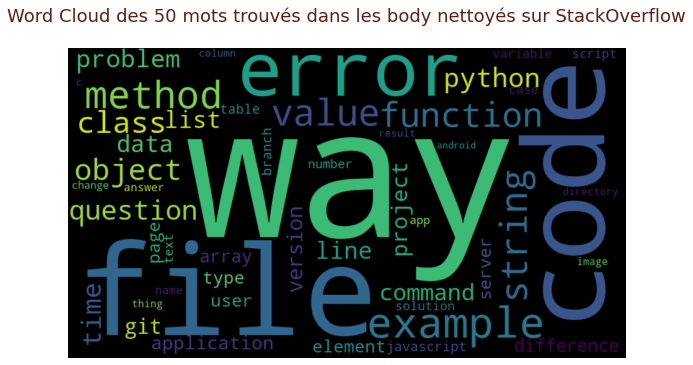

In [52]:
# Word cloud 
fig = plt.figure(1, figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(listBody.iloc[:50].to_dict()['Count'])

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud des 50 mots trouvés dans les body nettoyés sur StackOverflow\n",
          fontsize=18, color="#641E16")
plt.show()

In [49]:
listBodyTest = getWord('Body')
print(dataStack['Body'].head())

1    <p>In the past, I used Microsoft Web Application Stress Tool and Pylot to stress test web applications. I'd written a simple home page, login script, and site walkthrough (in an ecommerce site adding a few items to a cart and checkout).</p>\n\n<p>Just hitting the homepage hard with a handful of developers would almost always locate a major problem. More scalability problems would surface at the second stage, and even more - after the launch.</p>\n\n<p>The URL of the tools I used were Microsoft Homer (aka <a href="http://www.microsoft.com/downloads/details.aspx?familyid=e2c0585a-062a-439e-a67d-75a89aa36495&amp;displaylang=en" rel="noreferrer">Microsoft Web Application Stress Tool</a>) and <a href="https://code.google.com/archive/p/pylt/" rel="noreferrer">Pylot</a>.</p>\n\n<p>The reports generated by these tools never made much sense to me, and I would spend many hours trying to figure out what kind of concurrent load the site would be able to support. It was always worth it because

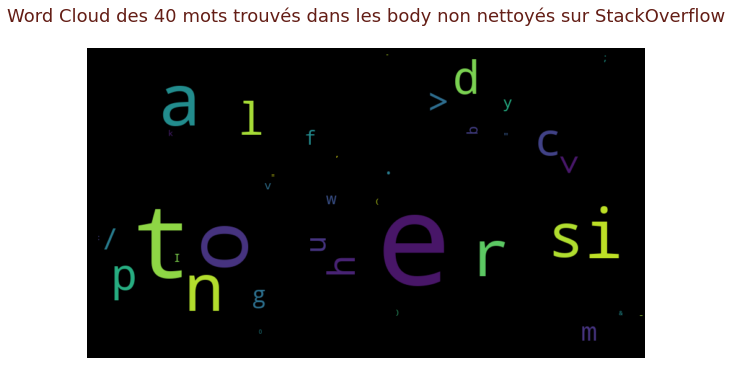

In [50]:
# Word cloud 
fig = plt.figure(1, figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(listBodyTest.iloc[:40].to_dict()['Count'])

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud des 40 mots trouvés dans les body non nettoyés sur StackOverflow\n",
          fontsize=18, color="#641E16")
plt.show()

# Data saved

In [51]:
dataStack[['Id','MainTags','MainWordBody','MainWordTitle','CreationYear']].to_csv("../QueryResults_Clear.csv",index=False)